<a href="https://colab.research.google.com/github/alexdoyle115/C7081_Assignment/blob/main/Using_neural_networks_to_classify_wheat_leaf_diseases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
# Importing the required packages
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras import models
#from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import load_model
import keras
keras.__version__

'2.4.3'

# Classifying wheat leaf disease using convolutional neural networks  

---



### Table of Contents

1.   Background
2.   Methods
3.   Results
4.   Discussion
5.   Literiture

### 1. Background

---



<P ALIGN=JUSTIFY> 
Wheat is a staple food of mankind with 765 million tonnes produced in 2019(FAOSTAT). It accounts for a fifth of humanity’s food, wheat is the second only to rice which provides 21% of the food calories and 20% of the protein for more than 4.5 billion people in 94 developing countries (Braun et al., 2010). 
<i>Puccina triticina</i> is a fungal disease of affecting a range of crops but most notably wheat crops worldwide. Also known as brown leaf rust it is widely recognised a one of the most important diseases, causing around a 4% reduction in yield reduction worldwide (Dulleiller et al., 2007) but reductions in up to 50% have been recorded (Draz et al, 2015). While leaf rusts have a complex lifestyle with both sexual and asexual reproduction as well as multiple hosts. For the purposes of this analysis the lifecycle is beyond the scope of this analysis. Importantly it occurs on the leaf blade with infections appearing as small round pustules with an orange, brown colour surrounded by a yellow ring of chlorotic leaf tissue, these very identifiable pustules contain the spores.
There are 2 main methods of controlling brown rust in fields, resistant varieties, and chemical sprays. The use of resistant varieties is much more in line with the rational of modern farming techniques. The main issue with resistant varieties is the appearance of new strains that can infect previously resist varieties. To combat this there are fungicides on the market that do offer control, but it is important to ensure that their effectiveness is not impacted.

To try and protect both cultural and chemicals controls effectiveness, it is key to utilise the pillars of Integrated Pest Management (IPM). This can be better achieved with the use of modern technologies such as precision agriculture. The rise of precision agriculture has allowed farming to gather more detailed data on smaller and smaller areas as well as machines more capable take full advantage of such systems.

Accurate automated high-throughput phenotyping of plant diseases has the potential to aid crop management, speed up breeding, and contribute to fundamental and applied research efforts (Pauli et al. 2016). With companies like the small robot company (link can be found [here](https://www.smallrobotcompany.com/)) being developed one could envision small mapping robots being used to travel the fields, identify high disease areas, and highlight these regions for chemical control. A system like this would allow for improved diagnosis and better use of chemical fungicides as well as removing the subjective nature from resistance scoring in crop trials (Bock et al. 2009).

While a system such as this may be seen in the future, there are several challenges for both the hardware and software to overcome. One such challenge is reliably distinguishing between a diseased plant and other forms of damage (DeChant et al. 2017). Image based identification is the best way to approach such a problem, by using Convolutional Neural Networks (CNN) to extract useful features from images without needing manual feature engineering. Using a CNN to correctly identify the presence of a leaf rust infection on the surface of a leaf when only comparing it to perfectly healthy leaves would be very simple, but not very practical any discolouring of the leaf could lead to an incorrect identification.

To add a layer of practicality a third class is included in the data, leaves that are nitrogen deficient. Nitrogen deficiency is the most common nutrient deficiency and results in paler green leaves with yellowing at the leaf tip reducing grain yield. The objective of this analysis is to correctly identify images of wheat leaves infected with leaf rust, leaves suffering with a nitrogen deficiency and leaves that are perfectly healthy.
</P>


The  Data 

---



<P ALIGN=JUSTIFY>
The data for this analysis consists of 1459 images of wheat leaves, split into 2 subsets Nitrogen Deficient(abiotic stress) and Rust(biotic stress) and further split outlined in Fig. 1. below(the number of images in each subset). 



Fig. 1.

Nitrogen Deficient | Rust 
---|---
**Train:** |
    N deficient (209)|Rust (258)
    Control (209)| Control(258)
**Test:** 
    N deficient (44)|Rust (54)
    Control (44)|Control (73)
**Validation:**
    N deficient (44)|Rust (54)
    Control (44)|Control(73) 



<P ALIGN=JUSTIFY>
The data was collected with an RGB camera from a wheat crop sown in the winter 2019 and harvested in 2020, the fields were a part of the Indian Agriculture Research Institute. The leaf images were acquired at the booting stage of a wheat crop. After the pictures were taken, the images were segmented from the background using Otsu-based masking (Arya et al. 2020).

The files for this analysis can be found at this [link](https://data.mendeley.com/datasets/th422bg4yd/1). 

In [42]:
# Connecting the notebook to google drive where the files are stored
from google.colab import drive 

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 2. Methods 

---



####2.1 Convoltional Neural Network

(-1.1105718540749925,
 1.1005034216226186,
 -1.1153801619227637,
 1.1007323886629887)

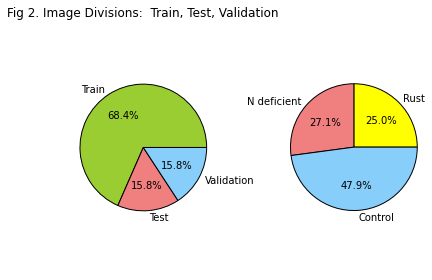

In [43]:
#@title
labels  = 'Train', 'Test', 'Validation'
type = 'Rust', 'N deficient', 'Control'
l_size =[932, 215, 215]
t_size = [366, 397, 701]
colours1 = ['yellowgreen', 'lightcoral', 'lightskyblue']
colours2 = ['yellow', 'lightcoral', 'lightskyblue']

plt.subplot(1, 2, 1)
plt.pie(l_size, labels = labels, colors = colours1, autopct='%1.1f%%', 
        wedgeprops={"edgecolor":"k",'linewidth': 1, 'antialiased': True})
plt.title('Fig 2. Image Divisions:  Train, Test, Validation')
plt.axis('equal')
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.pie(t_size, labels = type, colors = colours2, 
        autopct='%1.1f%%', wedgeprops={"edgecolor":"k",'linewidth': 1, 'antialiased': True})
plt.axis('equal')


Setting up the directories

---
<P ALIGN=JUSTIFY>
The files for this analysis were organised rather awkwardly, 2 seperate folders with 12 subfolders 6 of which are for control images. To reduce the complications the directories were set up to include all files in a single folder divided according to train, test and validation. This creates and organises the directories before filling them with the appropriate files. From the pie charts in Fig 2. it is clear that there is an imbalance in the number of samples in each class, almost half of all images are in the control class. Including all images in the model led to problems with accuracy and noise. By not including the images in one of the control folders it resulted in a more accurate consistant model. 

A link to a notebook including all images is attached [here](https://)

In [44]:
# Identifying the folders with training, test and validation images.  
# Training images 
train_deficiency =('/content/gdrive/MyDrive/C7082_Assignment/Ndeficient/train/deficiency')
train_controlN = ('/content/gdrive/MyDrive/C7082_Assignment/Ndeficient/train/control')

train_diseased = ('/content/gdrive/MyDrive/C7082_Assignment/WheatLeafRust/train/diseased')
train_controlR = ('/content/gdrive/MyDrive/C7082_Assignment/WheatLeafRust/train/control')

# Testing images
test_deficiency = ('/content/gdrive/MyDrive/C7082_Assignment/Ndeficient/test/deficiency')
test_controlN = ('/content/gdrive/MyDrive/C7082_Assignment/Ndeficient/test/control')

test_diseased = ('/content/gdrive/MyDrive/C7082_Assignment/WheatLeafRust/test/diseased')
test_controlR = ('/content/gdrive/MyDrive/C7082_Assignment/WheatLeafRust/test/control')

# Validation images
val_deficiency = ('/content/gdrive/MyDrive/C7082_Assignment/Ndeficient/val/deficiency')
val_controlN = ('/content/gdrive/MyDrive/C7082_Assignment/Ndeficient/val/control')

val_diseased = ('/content/gdrive/MyDrive/C7082_Assignment/WheatLeafRust/val/diseased')
val_controlR = ('/content/gdrive/MyDrive/C7082_Assignment/WheatLeafRust/val/control')

In [45]:
# Creating a new directory to organise files to suit the Neural Network
cwd = os.getcwd()
NN_dir = '/content/gdrive/MyDrive/C7082_Assignment/NN_dir'
os.mkdir(NN_dir)


In [46]:
# The training, validation and tests directories
train_dir = os.path.join(NN_dir, 'train')
os.mkdir(train_dir)

val_dir = os.path.join(NN_dir, 'val')
os.mkdir(val_dir)

test_dir = os.path.join(NN_dir, 'test')
os.mkdir(test_dir)

In [47]:
# The nitrogen deficent, leaf rust and control directories 
# Training directory
train_ndef_dir = os.path.join(train_dir, 'ndef')
os.mkdir(train_ndef_dir)

train_rust_dir = os.path.join(train_dir, 'rust')
os.mkdir(train_rust_dir)

train_control_dir = os.path.join(train_dir, 'control')
os.mkdir(train_control_dir)

# Test directories
test_ndef_dir = os.path.join(test_dir, 'ndef')
os.mkdir(test_ndef_dir)

test_rust_dir = os.path.join(test_dir, 'rust')
os.mkdir(test_rust_dir)

test_control_dir = os.path.join(test_dir, 'control')
os.mkdir(test_control_dir)

# Validation directories
val_ndef_dir = os.path.join(val_dir, 'ndef')
os.mkdir(val_ndef_dir)

val_rust_dir = os.path.join(val_dir, 'rust')
os.mkdir(val_rust_dir)

val_control_dir = os.path.join(val_dir, 'control')
os.mkdir(val_control_dir)

The various directories are filled with the coresponding images from the original data. 



In [48]:
# 1. Copy images into training directory (training)
fnames = ['{}.jpg'.format(i) for i in range(209)]
for fname in fnames:
  src = os.path.join(train_deficiency, fname)
  dst = os.path.join(train_ndef_dir, fname)
  shutil.copy(src, dst)

# 2. Nitrogen deficiency control images (training)
fnames = ['{}.jpg'.format(i) for i in range(209)]
for fname in fnames:
  src = os.path.join(train_controlN, fname)
  dst = os.path.join(train_control_dir, fname)
  shutil.copy(src, dst)

# 3. Leaf rust diseased images (training)
fnames = ['{}.jpg'.format(i) for i in range(258)]
for fname in fnames:
  src = os.path.join(train_diseased, fname)
  dst = os.path.join(train_rust_dir, fname)
  shutil.copy(src, dst)

# 4. Leaf rust control images (training) 
fnames = ['{}.jpg'.format(i) for i in range(258)]
for fname in fnames:
  src = os.path.join(train_controlR, fname)
  dst = os.path.join(train_control_dir, fname)
  shutil.copy(src, dst)

# 5. Nitrogen deficiency test images 
fnames = ['{}.jpg'.format(i) for i in range(44)]
for fname in fnames:
  src = os.path.join(test_deficiency, fname)
  dst = os.path.join(test_ndef_dir, fname)
  shutil.copy(src, dst)

# 6. Nitrogen deficency test control
fnames = ['{}.jpg'.format(i) for i in range(44)]
for fname in fnames:
  src = os.path.join(test_controlN, fname)
  dst = os.path.join(test_control_dir, fname)
  shutil.copy(src, dst)

# 7. Leaf rust test images 
fnames = ['{}.jpg'.format(i) for i in range(54)]
for fname in fnames:
  src = os.path.join(test_diseased, fname)
  dst = os.path.join(test_rust_dir, fname)
  shutil.copy(src, dst)

# 8. Leaf rust test control
fnames = ['{}.jpg'.format(i) for i in range(73)]
for fname in fnames:
  src = os.path.join(test_controlR, fname)
  dst = os.path.join(test_control_dir, fname)
  shutil.copy(src, dst)

# 9. Nitrogen deficiency val 
fnames = ['{}.jpg'.format(i) for i in range(44)]
for fname in fnames:
  src = os.path.join(val_deficiency, fname)
  dst = os.path.join(val_ndef_dir, fname)
  shutil.copy(src, dst)

# 10. Nitrogen deficency val control
fnames = ['{}.jpg'.format(i) for i in range(44)]
for fname in fnames:
  src = os.path.join(val_controlN, fname)
  dst = os.path.join(val_control_dir, fname)
  shutil.copy(src, dst)

# 11. Leaf rust val
fnames = ['{}.jpg'.format(i) for i in range(54)]
for fname in fnames:
  src = os.path.join(val_diseased, fname)
  dst = os.path.join(val_rust_dir, fname)
  shutil.copy(src, dst)

# 12. Leaf rust val control
fnames = ['{}.jpg'.format(i) for i in range(73)]
for fname in fnames:
  src = os.path.join(val_controlR, fname)
  dst = os.path.join(val_control_dir, fname)
  shutil.copy(src, dst)

Then just to check that the files are appropriatley filled.

In [49]:
print('total nitrogen deficeicent training images', len(os.listdir(train_ndef_dir)))
print('total rust infected training images', len(os.listdir(train_rust_dir)))
print('total nitrogen deficeicent control images', len(os.listdir(train_control_dir)))

total nitrogen deficeicent training images 209
total rust infected training images 258
total nitrogen deficeicent control images 258


#### The Neural Network
<P ALIGN=JUSTIFY>
The neural network in this analysis is a basic covenet using alternating layers of
<ul> 
<li>Conv2D - learns local patterns </li>
<li>Maxpooling - Extracting windows from the input feature map and outputting the max value in each channel </li>
<li>Dense - learns global patterns in their feature input space</li>
</ul>

The model is based off the convolutional neural network used to classify cat and dog images in "Deep Learning with Python" (Chollet, 2018), the binary classification problem uses hidden layers alternating between Conv2D and Maxpooling to identify local patterns such as edges, with dense layers to identify these local patterns. The main difference between my model and the dog and cat one is that the dog and cat one uses binary classification by utilizing the sigmoid activation. To correctly identify the 3 different classes (Nitrogen Deficient, Leaf Rust and Healthy) the 'SoftMax' activation is used with 3 classes. (Chollet, 2018). On a model such as this with such a small dataset overfitting will be the biggest problem to overcome. 
</P>

In [50]:
# Rust identifier model
from keras import regularizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 70, 70, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 33, 33, 128)       73856     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 31, 31, 128)      

<P ALIGN=JUSTIFY>
Looking at the model summary we see the vaious layers along with depth and size of the feature maps. The feature size (148x148) is somewhat arbitrary and is decreasing though the max pooling layers while the feature depth starts at 32 increasing to 128 before flattening. In 'Deep learning with Python' it highlights that 'rmsprop' is a suitable optimizer for the majority of applications as it reduces the decay of the learning rate (Lakshmi & Zhou, 2000) and breaks down the appropriate last-layer activation (for multiclass, single label classification the softmax activation and categorical_crossenthropy as the loss function) (Challot, 2018).



In [51]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Image Preprocessing


Using keras's `prepossing.image` packages it automatically converts the jpeg files from a RGB grid of pixels into tensors that are rescaled to be between 0 and 1 which works better in neural networks. 
The images are broken up into batches of 20 tensors. The 20 images are resized to 150 *150 which is arbitrary but important to keep consistant images fed into the model. As the images are colour, individual tensors are created for the each of the red, green, blue colour layers resulting in 3 different tensors in the input.  The resulting rezised images are fed in the batchs of 20 into the model which accounts for 1 step in the epoch. This processing produces batches in the shape (`20, 150, 150, 3`). To check the images is in the correct class labels are created, as it is a classification problem into 3 classes it requires 3 different labels resultuing in batches of (`20, 3`). While augmenting the 

In [52]:
# All images will be rescaled by 1./255. 
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use categorical_crossentropy loss, we need classification labels
        class_mode='categorical')

# Rescaling the validation images  
val_datagen = ImageDataGenerator(rescale=1./255)

# The same process for the validation set 
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 725 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [53]:
# The test images are left alone
test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_directory(
        # This is the target directory
        test_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use categorical_crossentropy loss, we need classification labels
        class_mode='categorical')

Found 171 images belonging to 3 classes.


In [54]:
#Takes the samples of size 20 (batch size) iterativly for the model, the generator will do this endlessly therefor a 'break' is required to stop it. 
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20, 3)


##### Running the model
<P ALIGN=JUSTIFY>
Once the data is in a suitable format for the model, it is now fit our model using the `model.fit`. The data is being generated in batches of 20 inputs indefinatly, therefore the generator needs to know how many samples to to draw from the generator before declaring an epoch. In this case there are 722 training images, with 20 images per batch, it will take 36 stepsh to run all images through. 

In [73]:
history = model.fit( train_generator, steps_per_epoch=36, epochs = 25,
  validation_data=validation_generator,
  validation_steps=2)

Epoch 1/25
36/36 [==============================] - 138s 4s/step - loss: 1.1809 - accuracy: 0.3617 - val_loss: 1.0847 - val_accuracy: 0.5000
Epoch 2/25
36/36 [==============================] - 136s 4s/step - loss: 1.1089 - accuracy: 0.3404 - val_loss: 1.0888 - val_accuracy: 0.5000
Epoch 3/25
36/36 [==============================] - 136s 4s/step - loss: 1.0635 - accuracy: 0.4043 - val_loss: 2.7293 - val_accuracy: 0.2500
Epoch 4/25
36/36 [==============================] - 138s 4s/step - loss: 1.0828 - accuracy: 0.5418 - val_loss: 0.8031 - val_accuracy: 0.7250
Epoch 5/25
36/36 [==============================] - 135s 4s/step - loss: 0.7440 - accuracy: 0.7546 - val_loss: 0.8595 - val_accuracy: 0.5750
Epoch 6/25
36/36 [==============================] - 135s 4s/step - loss: 0.5545 - accuracy: 0.7901 - val_loss: 0.3182 - val_accuracy: 0.9000
Epoch 7/25
36/36 [==============================] - 135s 4s/step - loss: 0.6323 - accuracy: 0.8355 - val_loss: 0.3525 - val_accuracy: 0.9000
Epoch 8/25
36

In [74]:
model.save('Rust_identifier_1')

INFO:tensorflow:Assets written to: Rust_identifier_1/assets


### 3. Results

<P ALIGN=JUSTIFY>
By passing the various subsets of images through the neural network it has trained the hidden units in the layers to take a series of numbers and use these numbers to estimate what group each image belongs. The results are plotted by comparing the training data and the validation data. Looking at the training data there is big jumps in the accuracy in the first 4 epochs, but this slows as it approaches 100% accuracy. It never reaches 1:1 prediction accuracy but in the final epoch it results in 97.02% prediction accuracy. Unfortunately, the same cannot be said for the validation accuracy which is much more important. There is an inconsistency with networks ability to correctly predict the model, the erratic highs, and lows of seen in the plot may be caused by the small number of images available. The highest level of accuracy achieved was 97.5% on the 12th epoch the following iterations resulted in a drop off in accuracy which may be contributed to overfitting.
</P>

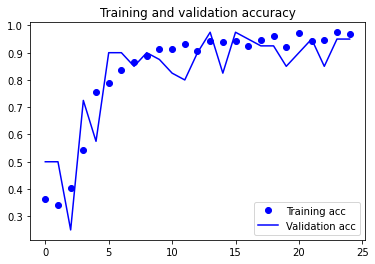

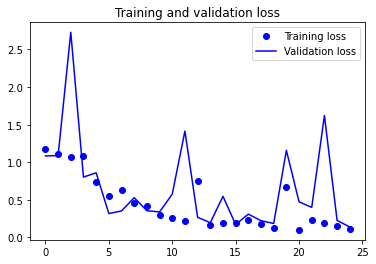

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

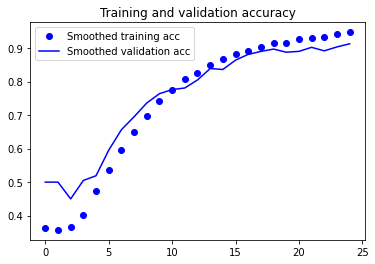

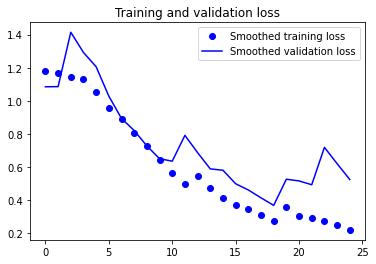

In [77]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Visulaising what the covnets learn



Visualing the the various layers of the convoltional neural network offers insight into what the "black box" that is a neural network is actually picking up on. The `Rust_identifier_1` model that was trained earlier in the analysis is reloaded as well as the `models`package in `keras`. The above image which is a leaf infected with stripes of rust. Ideally the model should see some activity in these regions.

In [78]:
model = load_model('Rust_identifier_1')

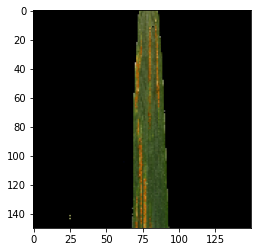

In [96]:
# Loading the image named 14.jpeg and then converting the file to a size 150 * 150 tensor
img_path = '/content/gdrive/MyDrive/C7082_Assignment/NN_dir/train/rust/14.jpg'

img = image.load_img(img_path, target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor/=255

plt.imshow(img_tensor[0])

# The image plotted below
plt.show()

In [97]:
# To view the multiple layers of the CNN the 1 input to the model gives 8 different outputs.
layers_output = [layer.output for layer in model.layers[:12]]
activation_model = models.Model(inputs=model.input, outputs=layers_output)


activations = activation_model.predict(img_tensor)

a_layer_activation = activations[0]
b_layer_activation = activations[1]
c_layer_activation = activations[2]
d_layer_activation = activations[3]
e_layer_activation = activations[4]
f_layer_activation = activations[5]
g_layer_activation = activations[6]
h_layer_activation = activations[7]
i_layer_activation = activations[8]
j_layer_activation = activations[9]
k_layer_activation = activations[10]
l_layer_activation = activations[11]
print(a_layer_activation.shape)

(1, 148, 148, 32)


Text(0.5, 1.0, '5th channel')

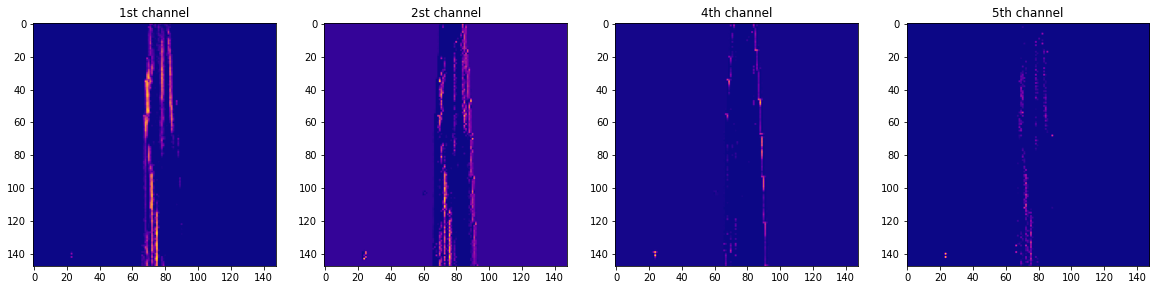

In [103]:
#Plotted below is the output of 4 channels in the first layer 
f, axarr =  plt.subplots(1,4, figsize=(20, 15))

axarr[0].imshow(a_layer_activation[0, :, :, 8], cmap='plasma')
axarr[0].set_title('1st channel')

axarr[1].imshow(a_layer_activation[0, :, :, 1], cmap='plasma')
axarr[1].set_title('2st channel')

axarr[2].imshow(a_layer_activation[0, :, :, 3], cmap='plasma')
axarr[2].set_title('4th channel')

axarr[3].imshow(a_layer_activation[0, :, :, 4], cmap='plasma')
axarr[3].set_title('5th channel')

Text(0.5, 1.0, '5th channel')

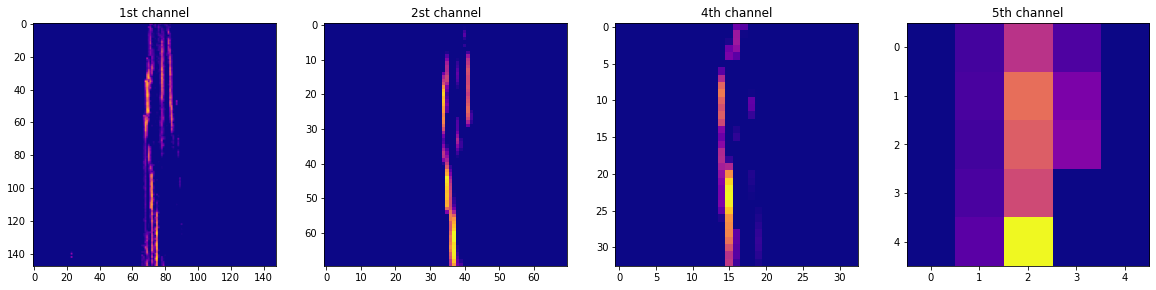

In [117]:
#Plotted below is the output of 4 channels in the first layer 
f, axarr =  plt.subplots(1,4, figsize=(20, 15))

axarr[0].imshow(a_layer_activation[0, :, :, 8], cmap='plasma')
axarr[0].set_title('1st channel')

axarr[1].imshow(d_layer_activation[0, :, :, 1], cmap='plasma')
axarr[1].set_title('2st channel')

axarr[2].imshow(f_layer_activation[0, :, :, 3], cmap='plasma')
axarr[2].set_title('4th channel')

axarr[3].imshow(k_layer_activation[0, :, :, 5], cmap='plasma')
axarr[3].set_title('5th channel')

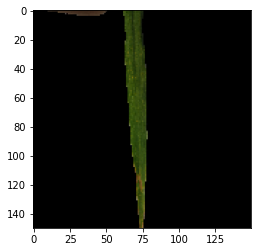

In [161]:
# Loading the image named 14.jpeg and then converting the file to a size 150 * 150 tensor
img_path = '/content/gdrive/MyDrive/C7082_Assignment/NN_dir/train/ndef/22.jpg'

img = image.load_img(img_path, target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor/=255

plt.imshow(img_tensor[0])

# The image plotted below
plt.show()

In [162]:
# To view the multiple layers of the CNN the 1 input to the model gives 8 different outputs.
activations = activation_model.predict(img_tensor)

a_layer_activation = activations[0]
b_layer_activation = activations[1]
c_layer_activation = activations[2]
d_layer_activation = activations[3]
e_layer_activation = activations[4]
f_layer_activation = activations[5]
g_layer_activation = activations[6]
h_layer_activation = activations[7]
i_layer_activation = activations[8]
j_layer_activation = activations[9]
k_layer_activation = activations[10]
l_layer_activation = activations[11]
print(a_layer_activation.shape)
print(first_layer_activation.shape)

(1, 148, 148, 32)
(1, 72, 72, 64)


Text(0.5, 1.0, '2st layer')

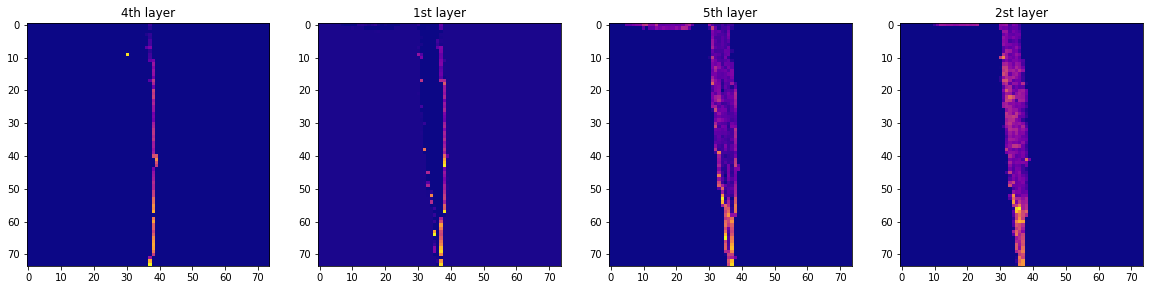

In [159]:
#Plotted below is the output of the 8 layers
f, axarr =  plt.subplots(1,4, figsize=(20, 15))

axarr[0].imshow(b_layer_activation[0, :, :, 0], cmap='plasma')
axarr[0].set_title('4th layer')

axarr[1].imshow(b_layer_activation[0, :, :, 3], cmap='plasma')
axarr[1].set_title('1st layer')

axarr[2].imshow(b_layer_activation[0, :, :, 9], cmap='plasma')
axarr[2].set_title('5th layer')

axarr[3].imshow(b_layer_activation[0, :, :, 19], cmap='plasma')
axarr[3].set_title('2st layer')

Text(0.5, 1.0, '5th channel')

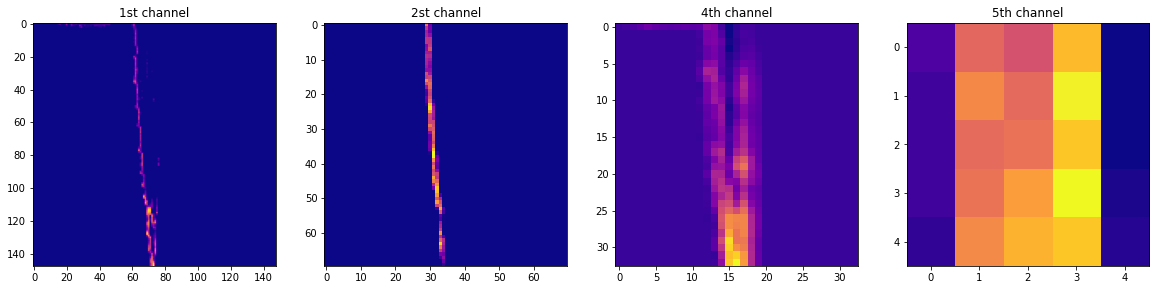

In [190]:
#Plotted below is the output of 4 channels in the first layer 
f, axarr =  plt.subplots(1,4, figsize=(20, 15))

axarr[0].imshow(a_layer_activation[0, :, :, 8], cmap='plasma')
axarr[0].set_title('1st channel')

axarr[1].imshow(d_layer_activation[0, :, :, 3], cmap='plasma')
axarr[1].set_title('2st channel')

axarr[2].imshow(f_layer_activation[0, :, :, 14], cmap='plasma')
axarr[2].set_title('4th channel')

axarr[3].imshow(k_layer_activation[0, :, :, 5], cmap='plasma')
axarr[3].set_title('5th channel')

<P ALIGN=JUSTIFY> When diagnosising nitrogen deficiency in wheat it would be hoped that the network would focus on the yellowing of the tips or possibly paler green colour but looking at the activations in the it indicates that it is picking up on the yellowing near the tips. In both cases the channnels in the first layer do pickup on these particular region for each disease and  are identified with subsequent layers highlighting the rust infection or yellowing of the tips. 

Comparing the images in the plot above we can see the output of the model that there is some alternation between layers and what they are highlighting. The first layer identifies the edges of the leaf blade and as the layers increase the amount of information available decreases and starts to become less visually interpretable but it is increasing the information about the class of the image. </P>

#### Testing the Accuracy of the model

In [160]:
# The test images are left alone
test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_directory(
        # This is the target directory
        test_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use categorical_crossentropy loss, we need classification labels
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=10,
        class_mode='categorical')

Found 171 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [87]:
for data_batch, labels_batch in test_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (10, 150, 150, 3)
labels batch shape: (10, 3)


In [88]:
test_loss, test_acc = model.evaluate(test_generator, steps=17)
test_acc= (round(test_acc, 5)) * 100
print('test acc:', test_acc,'%')

17/17 [==============================] - 20s 1s/step - loss: 0.1803 - accuracy: 0.9235
test acc: 92.353 %


### 4. Discussion
<P ALIGN=JUSTIFY>
While the results from the model are not perfect, they are encouraging. The Convoltional Neural Network was able to correctly classify images into 3 groups with an accuracy of over 92% on test data.  

There is potential for impoving the accuracy with a couple of tweaks and particularly through access to more images. Gathering a larger dataset may improve accuracy but would allow for greater consistency. I tried to gather some pictures of my own to test with the model, unfortunatly leaf rust infections are very rare at this early stage in the crop development it would normally be visable

A model such as this while very simple it could be built upon, as mentioned before further images to increase accuracy, images of leaves that have not been segmented from the background to make it more practical and the addition of a system to reliably take pictures and run them through the model would offer the option of installing it on a robot. With companies such as the small robot company (link can be found [here](https://www.smallrobotcompany.com/)) we could see a multitude of sensor robots sent into the fields to detect regions of disease through correct identification to allow for more efficent use of fertilizers and fungicides. Such a system would allow for impatiallity, by removing the human element from the diagnosis it could offer a more consistent picture of the area, this would be particularly useful in work such as resistance scoring in new crop varieties.
</P>
 

Outlined below is a string of code that can take a single image runs the image through the saved model and outputs an array. That array can then be put through an if statement and it prints the predicted class that the image belongs to. 



leaf rust infection


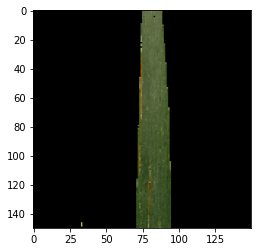

In [193]:
#@title Default title text
Example =('/content/gdrive/MyDrive/C7082_Assignment/Example')
fnames = [os.path.join(Example, fname) for fname in os.listdir(Example)]
integer_slider = 1 #@param {type:"slider", min:0, max:6, step:1}
img_path = fnames[integer_slider]

img = image.load_img(img_path, target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor/=255

plt.imshow(img_tensor[0])

preds = model.predict(img_tensor)
y_test=[np.argmax(preds) for preds in preds]
y_test = np.array(y_test)
if (y_test == 0):
  print("No disease")
elif (y_test == 1):
  print("nitrogen deficient")
else: 
  print("leaf rust infection")



### 5.Literiture
**Data**

**Arya, Sunny; Singh, Biswabiplab (2020), “Wheat nitrogen deficiency and leaf rust image dataset”, Mendeley Data, V1, doi: 10.17632/th422bg4yd.1**
 
 I.S. Draz, M.S. Abou-Elseoud, A.M. Kamara, O.A. Alaa El-Dein, A.F. EL-Bebany,
Screening of wheat genotypes for leaf rust resistance along with grain yield, Ann.
Agric. Sci. 60 (2015) 29–39.

Goutam, U., Kukreja, S., Yadav, R., Salaria, N., Thakur, K. and Goyal, A.K., 2015. Recent trends and perspectives of molecular markers against fungal diseases in wheat. Frontiers in microbiology, 6, p.861.

Bock, C.H., Parker, P.E., Cook, A.Z., Riley, T. and Gottwald, T.R., 2009. Comparison of assessment of citrus canker foliar symptoms by experienced and inexperienced raters. Plant Disease, 93(4), pp.412-424.

Lakshmi, S.M. and Zhou, S., Informix Software Inc, 2000. Optimizer with neural network estimator. U.S. Patent 6,108,648.

Pauli, D., Chapman, S.C., Bart, R., Topp, C.N., Lawrence-Dill, C.J., Poland, J. and Gore, M.A., 2016. The quest for understanding phenotypic variation via integrated approaches in the field environment. Plant Physiology, 172(2), pp.622-634.

E. Duveiller, R. Singh, J. Nicol,The challenges of maintaining wheat productivity: pests, diseases, and potential epidemics, Euphytica, 157 (2007), pp. 417-430

**Accurate automated high-throughput phenotyping of plant diseases has the potential to aid crop management, speed up breeding, and contribute to fundamental and applied research efforts (Pauli et al. 2016).**

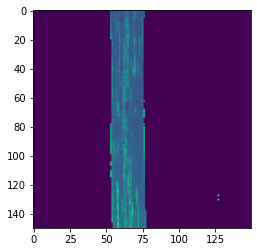

In [71]:
plt.imshow(img_tensor[0][:,:,1 ])
plt.show()

In [72]:
y_test=[np.argmax(preds) for preds in preds]
y_test = np.array(y_test)
if (y_test == 0):
  print("No disease")
elif (y_test == 1):
  print("nitrogen deficient")
else: 
  print("leaf rust infection")

No disease
